In [2]:
# -- Authors: Paula Gálvez Molina and Valentina Contreras Rojas
# Last Modified: Oct. 20th, 2025

In [1]:
import sys
from os.path import isfile

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from itertools import combinations
from matplotlib.colors import LogNorm

In [4]:
# Read in raw data
url = "https://github.com/juanserrano90/codelatam/raw/main/Data/data/sn_data.parquet"
df_raw = pd.read_parquet(url)
df_raw = df_raw.reset_index(drop=False) # Make SN Name be another column instead of index value, will create an unique index for each row
df_raw.head()

,SN Name,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,sn2008ar,Ia-norm,0,Ia,0,-8.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sn2008ar,Ia-norm,0,Ia,0,-7.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sn2008ar,Ia-norm,0,Ia,0,-6.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sn2008ar,Ia-norm,0,Ia,0,-4.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sn2008ar,Ia-norm,0,Ia,0,-3.7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Getting wavelengths
wavelength = np.array([float(c) for c in df_raw.columns[6:]])
wavelength.shape

(1024,)

In [6]:
# Remove row with outlier flux
df = df_raw.drop(df_raw.loc[df_raw['3301.9'] == 2071.001].index)
df.describe()

,SN Subtype ID,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,2515.28,2518.69,2522.1,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
count,5000.000000,5000.0000,5000.000000,5000.0,5000.0,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.0
mean,3.992800,0.6550,36.549182,0.0,0.0,8.000000e-07,0.000005,0.000010,0.000007,0.000019,...,0.000019,0.000096,0.000045,0.000058,0.000027,0.000024,0.000010,0.000005,0.0,0.0
std,5.162565,1.0242,88.023430,0.0,0.0,2.827578e-05,0.000130,0.000244,0.000330,0.000641,...,0.005264,0.004878,0.003671,0.002664,0.001600,0.001002,0.000429,0.000113,0.0,0.0
min,0.000000,0.0000,-82.700000,0.0,0.0,0.000000e+00,-0.002000,-0.003000,-0.008000,-0.005000,...,-0.059000,-0.038000,-0.059000,-0.021000,-0.012000,-0.008000,-0.003000,-0.001000,0.0,0.0
25%,0.000000,0.0000,-0.200000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,1.000000,0.0000,11.900000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,8.000000,1.0000,36.100000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,16.000000,3.0000,1103.000000,0.0,0.0,1.000000e-03,0.004000,0.009000,0.015000,0.025000,...,0.107000,0.153000,0.071000,0.052000,0.036000,0.022000,0.009000,0.002000,0.0,0.0


In [7]:
#--Scaling fluxes to calculate magnitudes
min_val, max_val = 1e-5, 100
fluxes = df.iloc[:, 6:].to_numpy()
fluxes = fluxes.T # Transposing as MinMaxScaler scales columnwise and we want to scale by spectrum not wavelength
scaler = MinMaxScaler(feature_range=(min_val, max_val))
fluxes_scaled = scaler.fit_transform(fluxes)
print(fluxes.min(), fluxes_scaled.min(), '\n', fluxes.max(), fluxes_scaled.max()) # Double checking scaling worked (should be between 1e-5 and 100)
fluxes_scaled = fluxes_scaled.T  # Transposing back for further manipulation

-17.943 9.999999999621423e-06 
 56.627 100.00000000000003


In [8]:
# Define required functions
def get_dm_dw(sn_flux, wavelength):
    # Convert flux to magnitude
    mags = np.log10(sn_flux)

    # Generate all unique index pairs (1024 choose 2 as there are 1024 flux values per spectra)
    idx_pairs = list(combinations(range(len(mags)), 2))

    # Compute dm and dw using indices
    dm = [abs(mags[i] - mags[j]) for i, j in idx_pairs]
    dw = [abs(wavelength[i] - wavelength[j]) for i, j in idx_pairs]

    return np.array(dm), np.array(dw)

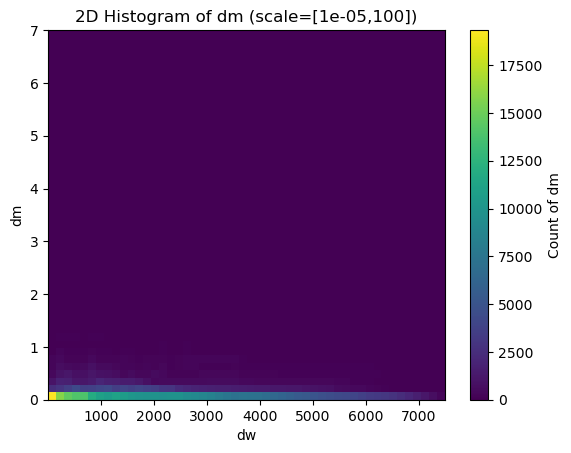

In [9]:
dm, dw = get_dm_dw(fluxes_scaled[12], wavelength)
plt.hist2d(dw, dm, bins=(50, 50), cmap=plt.cm.viridis)
plt.colorbar(label='Count of dm')
plt.title(f'2D Histogram of dm (scale=[{min_val},{max_val}])')
plt.xlabel('dw')
plt.ylabel('dm')
plt.show()

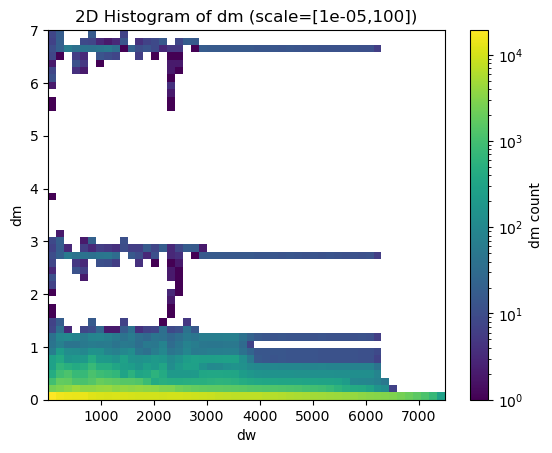

In [10]:
dm, dw = get_dm_dw(fluxes_scaled[12], wavelength)
plt.hist2d(dw, dm, bins=(50, 50), cmap=plt.cm.viridis, norm=LogNorm())
plt.colorbar(label='dm count')
plt.title(f'2D Histogram of dm (scale=[{min_val},{max_val}])')
plt.xlabel('dw')
plt.ylabel('dm')
plt.show()

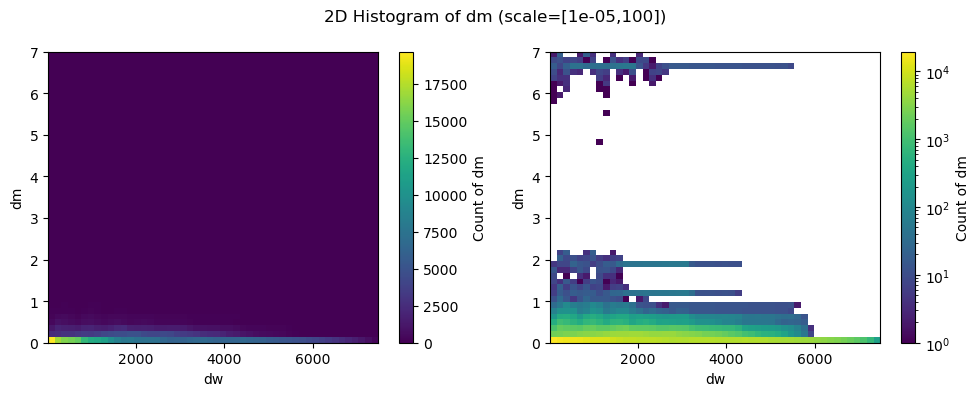

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
dm, dw = get_dm_dw(fluxes_scaled[3312], wavelength)
plt.suptitle(f'2D Histogram of dm (scale=[{min_val},{max_val}])')

# Plot on the first subplot
h1 = axs[0].hist2d(dw, dm, bins=(50, 50), cmap=plt.cm.viridis)
fig.colorbar(h1[3], ax=axs[0], label='Count of dm')
axs[0].set_xlabel('dw')
axs[0].set_ylabel('dm')

# Plot on the second subplot
h2 = axs[1].hist2d(dw, dm, bins=(50, 50), cmap=plt.cm.viridis, norm=LogNorm())
fig.colorbar(h2[3], ax=axs[1], label='Count of dm')
axs[1].set_xlabel('dw')
axs[1].set_ylabel('dm')

plt.tight_layout()


Text(0.5, 1.0, 'dm histogram')

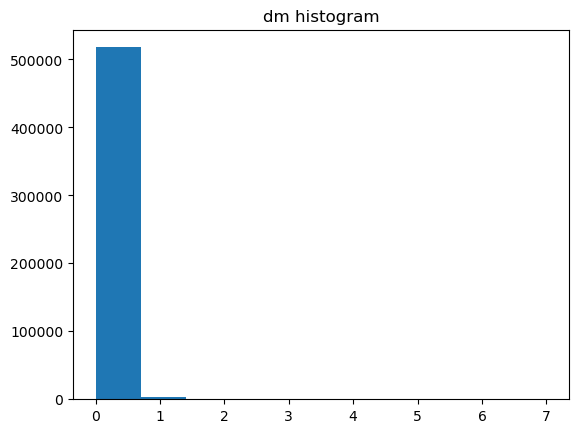

In [14]:
plt.hist(dm)
# plt.yscale('log')
plt.title('dm histogram')